# Initialisation

In [1]:
qualitatives_attributes_col_idx <- c(4,6,7,9,10,11)
discretized_quantitatives_attributes_col_idx <- c(4,6)
quantitatives_attributes_col_idx <- c(2,3,5)
target_variables_idx <- 8
datasets_directory <- "../datasets/"
dataset_filename <- "HR_prediction-all.csv"
output_folder <- "output"
working_directory <- "C:/Users/huniv/jnotebook/data-mining/62-62_Data_Mining/tp01/"

In [2]:
# Install packages if not already installed
if (!requireNamespace("gridExtra", quietly = TRUE)) {
  install.packages("gridExtra")
}
if (!requireNamespace("png", quietly = TRUE)) {
  install.packages("png")
}
if (!requireNamespace("latex2exp", quietly=TRUE)) {
  install.packages("latex2exp")
}
if (!requireNamespace("corrplot", quietly = TRUE)) {
  install.packages("corrplot")
}
if (!require("arules", quietly = TRUE)) {
  install.packages("arules")
}

# Load required libraries
library(gridExtra)
library(grid)
library(latex2exp)
library(corrplot)
library(arules)


Attaching package: 'arules'


The following objects are masked from 'package:base':

    abbreviate, write


corrplot 0.95 loaded



In [3]:
# Function to create an output directory if it doesn't exist
ensure_output_directory <- function(wd, folder_name) {
  output_dir <- file.path(wd, folder_name)
  if (!dir.exists(output_dir)) {
    dir.create(output_dir, recursive = TRUE)
  }
  return(output_dir)
}

In [4]:
setwd(datasets_directory)
data <- read.table (file=dataset_filename,sep=",", header=T)

# Preliminary Analysis

In [5]:
nb_instances <- nrow(data)
nb_attributes <- ncol(data)

print(paste("Number of instances : ", nb_instances))
print("#####")
print(paste("Number of attributes : ", nb_attributes))

[1] "Number of instances :  10000"
[1] "#####"
[1] "Number of attributes :  11"


In [6]:
summary(data)

       Id        satisfaction_level last_evaluation  number_project 
 Min.   :    3   Min.   :0.090      Min.   :0.3600   Min.   :2.000  
 1st Qu.: 3728   1st Qu.:0.440      1st Qu.:0.5600   1st Qu.:3.000  
 Median : 7434   Median :0.640      Median :0.7200   Median :4.000  
 Mean   : 7471   Mean   :0.614      Mean   :0.7176   Mean   :3.799  
 3rd Qu.:11243   3rd Qu.:0.820      3rd Qu.:0.8700   3rd Qu.:5.000  
 Max.   :14999   Max.   :1.000      Max.   :1.0000   Max.   :7.000  
 average_montly_hours time_spend_company Work_accident         left       
 Min.   : 96.0        Min.   : 2.000     Min.   :0.0000   Min.   :0.0000  
 1st Qu.:156.0        1st Qu.: 3.000     1st Qu.:0.0000   1st Qu.:0.0000  
 Median :199.0        Median : 3.000     Median :0.0000   Median :0.0000  
 Mean   :200.7        Mean   : 3.494     Mean   :0.1459   Mean   :0.2381  
 3rd Qu.:245.0        3rd Qu.: 4.000     3rd Qu.:0.0000   3rd Qu.:0.0000  
 Max.   :310.0        Max.   :10.000     Max.   :1.0000   Max.   :1

In [55]:
# Function to analyze the target variable
analyzeTargetVariable <- function(data, target_idx) {
  
  # Calculate distribution and probability of target variable
  target_counts <- table(data[, target_idx])
  print(target_counts)

  mode_value <- names(which.max(target_counts))
  print(paste("Mode of Target Variable:", mode_value))

  # Plot the distribution of the target variable
  barplot(target_counts,
          main = paste("Distribution of variable", colnames(data)[target_idx]),
          xlab = colnames(data)[target_idx],
          ylab = "Count")

  # Calculate and print the probability distribution of the target variable
  P_target <- prop.table(target_counts)
  print(P_target)

  # Plot the probability distribution of the target variable
  barplot(P_target,
          main = paste0("Probability distribution of variable P(", colnames(data)[target_idx], ")"),
          xlab = colnames(data)[target_idx],
          ylab = "Probability")
  
}


   0    1 
7619 2381 
[1] "Mode of Target Variable: 0"

     0      1 
0.7619 0.2381 


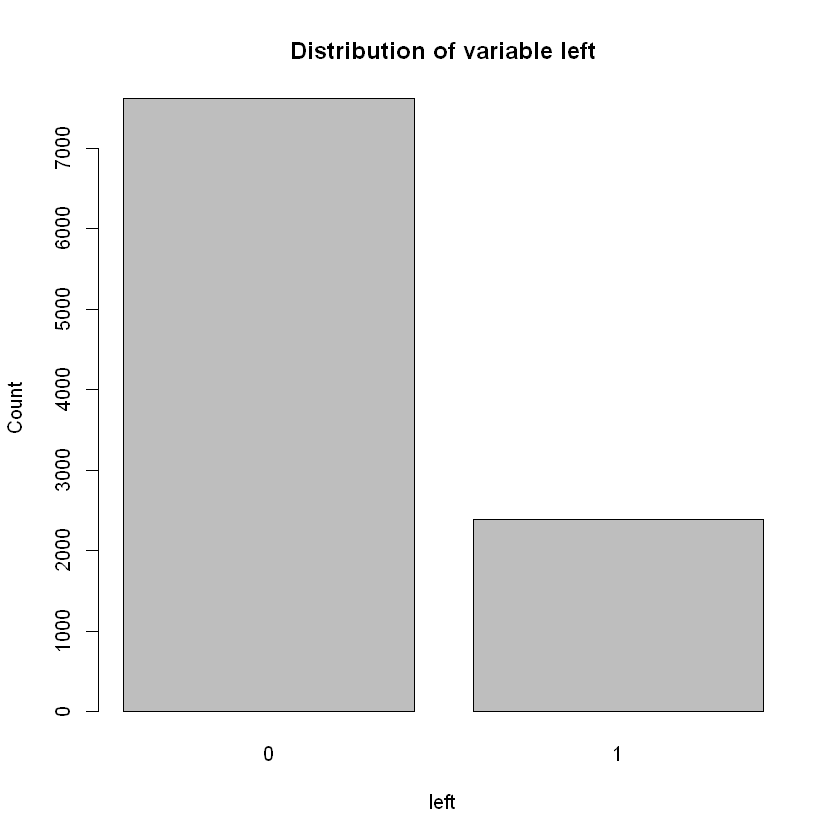

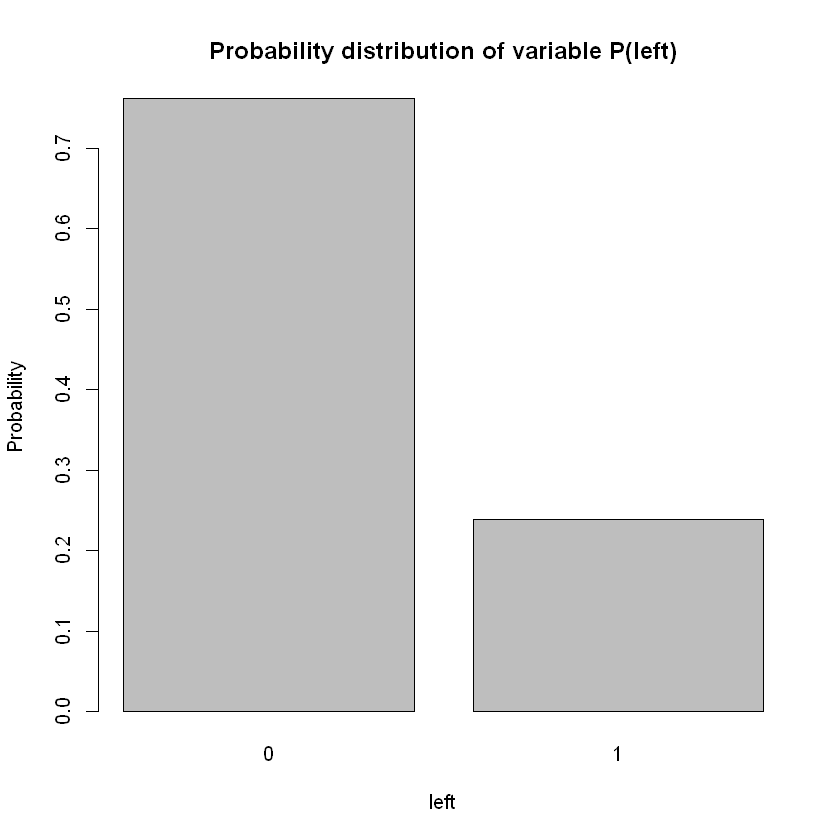

In [56]:
    analyzeTargetVariable(data, target_variables_idx)

In [9]:
# Function to analyze missing values in a dataset
analyzeDataQuality <- function(data) {

  # Find and count duplicate rows
  duplicates <- data[duplicated(data), ]
  print(paste("Number of duplicate rows:", nrow(duplicates)))
  if (nrow(duplicates) > 0) {
    print("Duplicate rows:")
    print(duplicates)
  }
  
  # SRC :https://www.geeksforgeeks.org/how-to-find-and-count-missing-values-in-r-dataframe/
  # Print the position of missing values
  cat("Position of missing values:\n")
  missing_positions <- which(is.na(data))
  print(missing_positions)

  # Count total missing values
  total_missing_values <- sum(is.na(data))
  cat("\nCount of total missing values:\n", total_missing_values, "\n")

  #SRC : https://www.datacamp.com/doc/r/missingdata
  # List rows of data that have missing values
  cat("\nRows with missing values:\n")
  rows_with_missing <- data[!complete.cases(data), ]
  print(rows_with_missing)

  return(list(
    missing_positions = missing_positions,
    total_missing_values = total_missing_values,
    rows_with_missing = rows_with_missing
  ))
}

In [10]:
analyzeDataQuality(data)

[1] "Number of duplicate rows: 0"
Position of missing values:
integer(0)

Count of total missing values:
 0 

Rows with missing values:
 [1] Id                    satisfaction_level    last_evaluation      
 [4] number_project        average_montly_hours  time_spend_company   
 [7] Work_accident         left                  promotion_last_5years
[10] department            salary               
<0 rows> (or 0-length row.names)


Id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>


# Qualitatives Attributes

In [11]:
# SRC :https://stat.ethz.ch/R-manual/R-devel/library/base/html/unique.html
#SRC https://www.statology.org/r-loop-through-data-frame-columns/
# Methods 1
sapply(data[, qualitatives_attributes_col_idx], unique)

$number_project
[1] 4 2 3 5 6 7

$time_spend_company
[1]  4  5  2  3  6  7  8 10

$Work_accident
[1] 0 1

$promotion_last_5years
[1] 0 1

$department
 [1] "marketing"   "sales"       "accounting"  "product_mng" "support"    
 [6] "technical"   "IT"          "management"  "hr"          "RandD"      

$salary
[1] "medium" "low"    "high"

In [12]:
# Function to plot and save probability distributions
plot_and_save_probabilities <- function(output_dir, var_name, P_var, P_target_given_var, target_name, discretized = FALSE) {
  
  # Create the full path for the PDF file
  file_suffix <- ifelse(discretized, "_discretized", "")
  full_pdf_path <- file.path(output_dir, paste0(var_name, file_suffix, ".pdf"))

  # Open a PDF to save the plots
  pdf(file = full_pdf_path, width = 12, height = 6)

  # Set up a 1-row, 2-column layout for the plots
  par(mfrow = c(1, 2), mar = c(7, 4, 4, 2) + 0.1)

  # Visualize the probability distribution P(variable)

  #Use las = 2 to Rotate x-axis labels for better visibility
  #Use cex.names = 0.6 to Reduce the label size slightly to fit
  barplot(P_var,
          main = paste0("Probability Distribution P(", var_name, ")"),
          xlab = paste0("Category of ", var_name),
          ylab = "Probability")
  


  # Visualize the conditional probability P(target | variable)
  barplot(P_target_given_var,
          beside = FALSE,
          main = paste0("Conditional Probability P(", target_name, " | ", var_name, ")"),
          xlab = paste0("Category of ", var_name),
          ylab = "Conditional Probability",
          legend.text = rownames(P_target_given_var),
          args.legend = list(x = "topright", inset = c(-0.1, 0), bty = "n"))

  # Close the PDF device
  dev.off()
  
}


# Function to analyze qualitative attributes without discretization
plot_probabilities <- function(wd, folder_name, data, variable_idx, target_idx) {
  # Get the names of the variable and target variable
  var_name <- tolower(trimws(colnames(data)[variable_idx]))
  target_name <- tolower(trimws(colnames(data)[target_idx]))

  # Ensure output directory exists
  output_dir <- ensure_output_directory(wd, folder_name)

  # Calculate the probability distribution P(variable)
  P_var <- prop.table(table(data[, variable_idx]))
  print(P_var)  # Display the probability distribution

  # Calculate the conditional probability P(target|variable)
  # Example : Observing employe who left the company among the employe who had a work accident instance
  # P(left=1 | work_accident = 1)
  P_target_given_var <- prop.table(table(data[, c(target_idx, variable_idx)]), margin = 2)
  print(P_target_given_var)  # Display the conditional probability

  # Plot and save the probabilities
  plot_and_save_probabilities(output_dir, var_name, P_var, P_target_given_var, target_name)
}

# Function to analyze qualitative attributes using discretization (with the arules package)
plot_probabilities_with_discretize <- function(wd, folder_name, data, variable_idx, target_idx, num_buckets = 3) {
  # Get the names of the variable and target variable
  var_name <- tolower(trimws(colnames(data)[variable_idx]))
  target_name <- tolower(trimws(colnames(data)[target_idx]))

  # Discretize the variable into the specified number of buckets
  binned_variable <- discretize(data[, variable_idx], method = "frequency", breaks = num_buckets)

  # Convert the binned variable to a factor
  binned_variable <- as.factor(binned_variable)

  # Ensure output directory exists
  output_dir <- ensure_output_directory(wd, folder_name)

  # Calculate probabilities
  # Calculate the probability distribution P(variable in buckets)
  P_var <- prop.table(table(binned_variable))
  print(P_var)  # Display the probability distribution

  # Calculate the conditional probability P(target | variable in buckets)
  P_target_given_var <- prop.table(table(data[, target_idx], binned_variable), margin = 2)
  print(P_target_given_var)  # Display the conditional probability

  # Plot and save the probabilities with discretized suffix
  plot_and_save_probabilities(output_dir, var_name, P_var, P_target_given_var, target_name, discretized = TRUE)
}

In [13]:
# Define the index of the variable and target variable
for (i in qualitatives_attributes_col_idx) {
  plot_probabilities(working_directory, output_folder, data, i, target_variables_idx)
}


     2      3      4      5      6      7 
0.1613 0.2670 0.2942 0.1828 0.0783 0.0164 
    number_project
left          2          3          4          5          6          7
   0 0.34779913 0.98314607 0.90992522 0.76641138 0.45338442 0.00000000
   1 0.65220087 0.01685393 0.09007478 0.23358862 0.54661558 1.00000000

     2      3      4      5      6      7      8     10 
0.2171 0.4325 0.1666 0.0984 0.0480 0.0126 0.0102 0.0146 
    time_spend_company
left          2          3          4          5          6          7
   0 0.98341778 0.75445087 0.65006002 0.43394309 0.70208333 1.00000000
   1 0.01658222 0.24554913 0.34993998 0.56605691 0.29791667 0.00000000
    time_spend_company
left          8         10
   0 1.00000000 1.00000000
   1 0.00000000 0.00000000

     0      1 
0.8541 0.1459 
    Work_accident
left          0          1
   0 0.73492565 0.91980809
   1 0.26507435 0.08019191

     0      1 
0.9789 0.0211 
    promotion_last_5years
left          0          1
   0 0.75799

In [14]:
# Define the index of the variable and target variable
for (i in discretized_quantitatives_attributes_col_idx) {
  plot_probabilities_with_discretize(working_directory, output_folder, data, i, target_variables_idx, 3)
}

binned_variable
 [2,3)  [3,4)  [4,7] 
0.1613 0.2670 0.5717 
   binned_variable
         [2,3)      [3,4)      [4,7]
  0 0.34779913 0.98314607 0.77540668
  1 0.65220087 0.01685393 0.22459332
binned_variable
 [2,3)  [3,4) [4,10] 
0.2171 0.4325 0.3504 
   binned_variable
         [2,3)      [3,4)     [4,10]
  0 0.98341778 0.75445087 0.63384703
  1 0.01658222 0.24554913 0.36615297


In [15]:
QualitativeAttrsTheory <- function(data, variable_idx, target_idx) {
        
    var_name <- trimws(colnames(data)[variable_idx])
    target_name <- trimws(colnames(data)[target_idx])
    
    # Calculate the joint probability distribution
    title <- paste("P(",var_name,",",target_name,")")
    P.var.target <- prop.table(table(data[,c(variable_idx,target_idx)]))
    barplot(P.var.target, main=title, legend=T)
  
    print("P(target, var):")
    print(P.var.target)
    print("########################")
    
    # Caculate marginale distribution P(Target)
    print("P(target):")
    P.target <- colSums(P.var.target)
    print("Check:")
    print(prop.table(table(data[,target_idx])))
    print(P.target)
    print("########################")

    # Caculate marginale distribution P(Variable)
    print("P(var):")
    P.var <- rowSums(P.var.target)
    print("Check:")
    print(prop.table(table(data[,variable_idx])))
    print(P.var)
    print("########################")
    
    P.target.given.var <- sweep(P.var.target,1,P.var, FUN="/")
    print("P(target|var):")
    print(P.target.given.var)
    print("Check:")
    print(rowSums(P.target.given.var))
    print("########################")

    P.var.given.target <- sweep(P.var.target,2,P.target, FUN="/")
    print("P(var|target):")
    print(P.var.given.target)
    print("Check:")
    print(colSums(P.var.given.target))
    print("########################")
}

[1] "P(target, var):"
              left
number_project      0      1
             2 0.0561 0.1052
             3 0.2625 0.0045
             4 0.2677 0.0265
             5 0.1401 0.0427
             6 0.0355 0.0428
             7 0.0000 0.0164
[1] "########################"
[1] "P(target):"
[1] "Check:"

     0      1 
0.7619 0.2381 
     0      1 
0.7619 0.2381 
[1] "########################"
[1] "P(var):"
[1] "Check:"

     2      3      4      5      6      7 
0.1613 0.2670 0.2942 0.1828 0.0783 0.0164 
     2      3      4      5      6      7 
0.1613 0.2670 0.2942 0.1828 0.0783 0.0164 
[1] "########################"
[1] "P(target|var):"
              left
number_project          0          1
             2 0.34779913 0.65220087
             3 0.98314607 0.01685393
             4 0.90992522 0.09007478
             5 0.76641138 0.23358862
             6 0.45338442 0.54661558
             7 0.00000000 1.00000000
[1] "Check:"
2 3 4 5 6 7 
1 1 1 1 1 1 
[1] "########################"
[1]

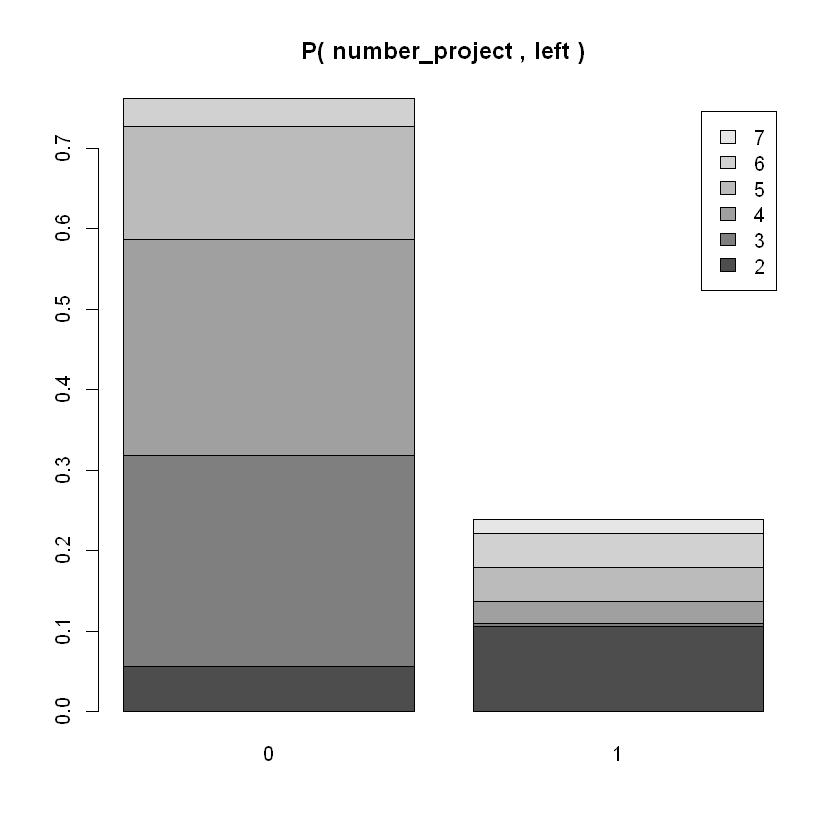

[1] "P(target, var):"
                  left
time_spend_company      0      1
                2  0.2135 0.0036
                3  0.3263 0.1062
                4  0.1083 0.0583
                5  0.0427 0.0557
                6  0.0337 0.0143
                7  0.0126 0.0000
                8  0.0102 0.0000
                10 0.0146 0.0000
[1] "########################"
[1] "P(target):"
[1] "Check:"

     0      1 
0.7619 0.2381 
     0      1 
0.7619 0.2381 
[1] "########################"
[1] "P(var):"
[1] "Check:"

     2      3      4      5      6      7      8     10 
0.2171 0.4325 0.1666 0.0984 0.0480 0.0126 0.0102 0.0146 
     2      3      4      5      6      7      8     10 
0.2171 0.4325 0.1666 0.0984 0.0480 0.0126 0.0102 0.0146 
[1] "########################"
[1] "P(target|var):"
                  left
time_spend_company          0          1
                2  0.98341778 0.01658222
                3  0.75445087 0.24554913
                4  0.65006002 0.34993998
          

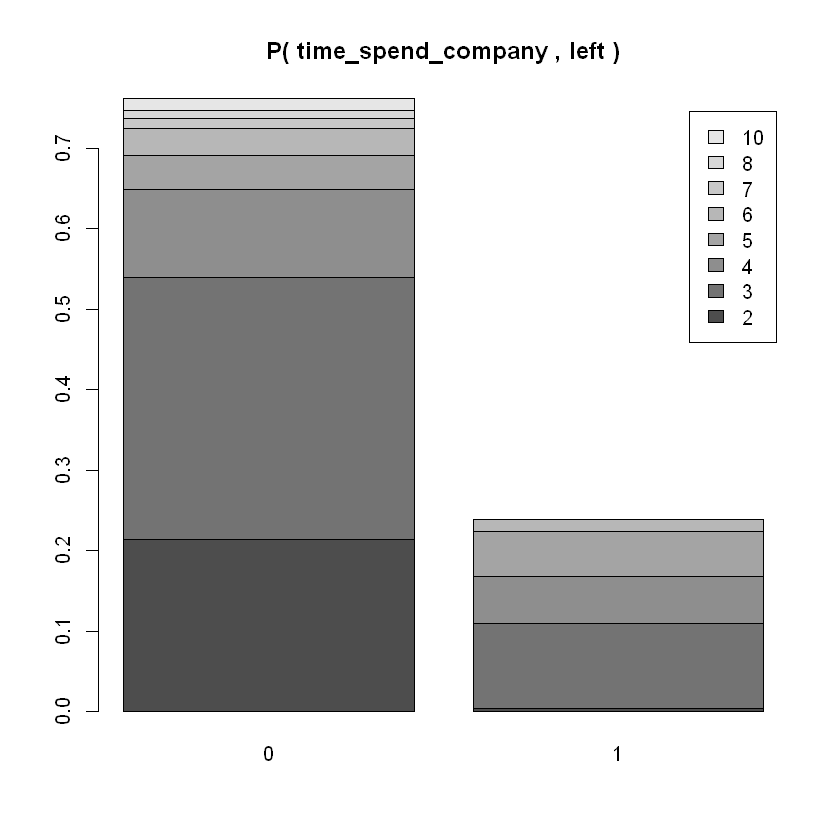

[1] "P(target, var):"
             left
Work_accident      0      1
            0 0.6277 0.2264
            1 0.1342 0.0117
[1] "########################"
[1] "P(target):"
[1] "Check:"

     0      1 
0.7619 0.2381 
     0      1 
0.7619 0.2381 
[1] "########################"
[1] "P(var):"
[1] "Check:"

     0      1 
0.8541 0.1459 
     0      1 
0.8541 0.1459 
[1] "########################"
[1] "P(target|var):"
             left
Work_accident          0          1
            0 0.73492565 0.26507435
            1 0.91980809 0.08019191
[1] "Check:"
0 1 
1 1 
[1] "########################"
[1] "P(var|target):"
             left
Work_accident          0          1
            0 0.82386140 0.95086098
            1 0.17613860 0.04913902
[1] "Check:"
0 1 
1 1 
[1] "########################"


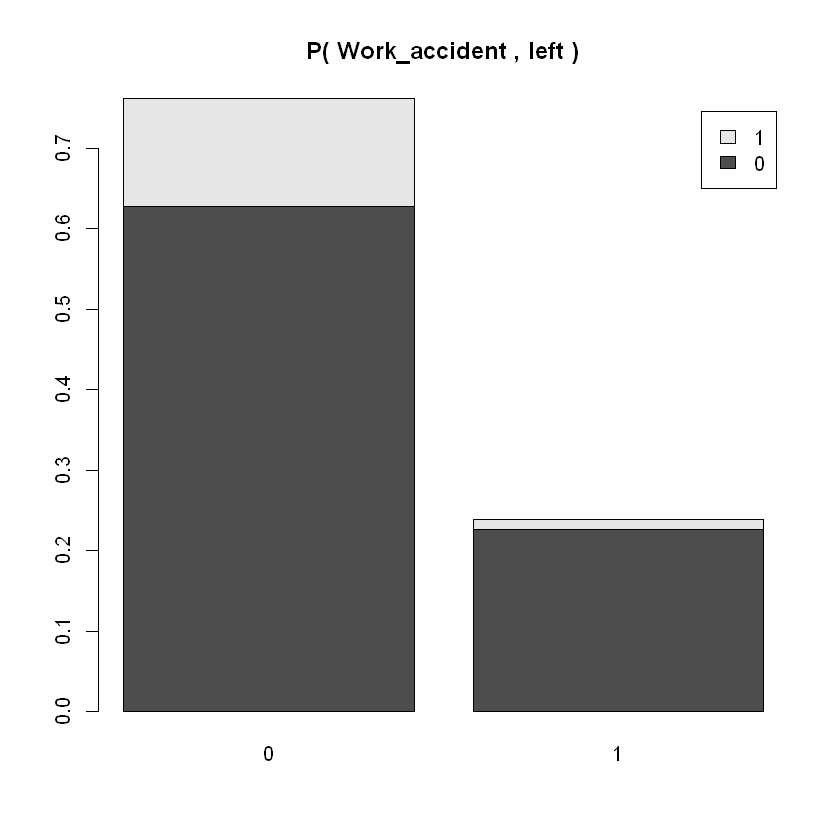

[1] "P(target, var):"
                     left
promotion_last_5years      0      1
                    0 0.7420 0.2369
                    1 0.0199 0.0012
[1] "########################"
[1] "P(target):"
[1] "Check:"

     0      1 
0.7619 0.2381 
     0      1 
0.7619 0.2381 
[1] "########################"
[1] "P(var):"
[1] "Check:"

     0      1 
0.9789 0.0211 
     0      1 
0.9789 0.0211 
[1] "########################"
[1] "P(target|var):"
                     left
promotion_last_5years          0          1
                    0 0.75799367 0.24200633
                    1 0.94312796 0.05687204
[1] "Check:"
0 1 
1 1 
[1] "########################"
[1] "P(var|target):"
                     left
promotion_last_5years           0           1
                    0 0.973881087 0.994960101
                    1 0.026118913 0.005039899
[1] "Check:"
0 1 
1 1 
[1] "########################"


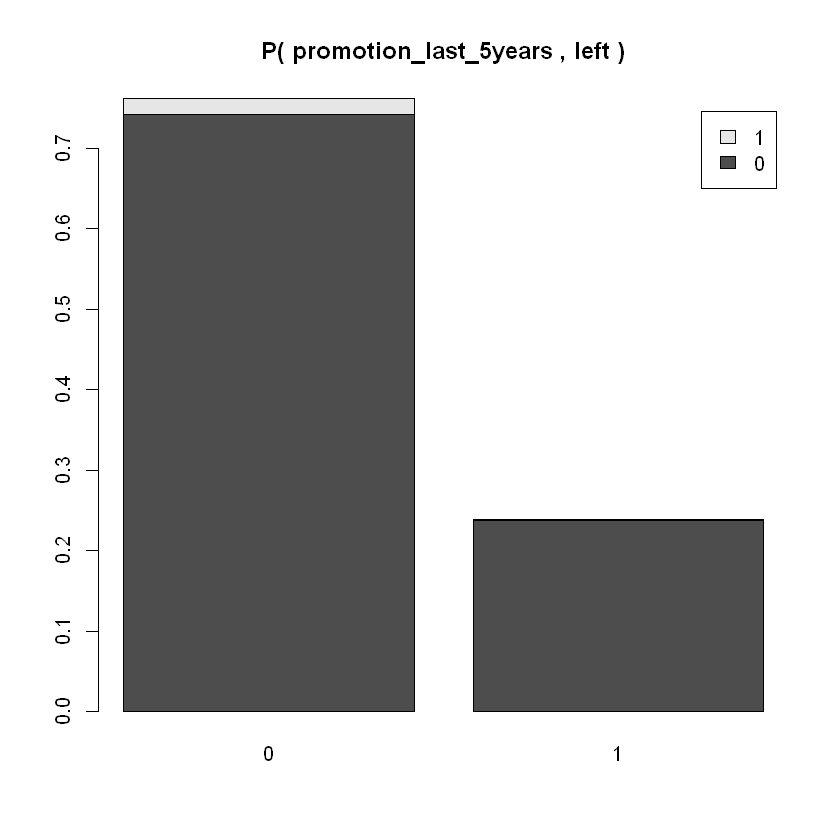

[1] "P(target, var):"
             left
department         0      1
  IT          0.0643 0.0182
  RandD       0.0450 0.0074
  accounting  0.0376 0.0141
  hr          0.0369 0.0134
  management  0.0355 0.0065
  marketing   0.0423 0.0128
  product_mng 0.0485 0.0123
  sales       0.2091 0.0699
  support     0.1105 0.0376
  technical   0.1322 0.0459
[1] "########################"
[1] "P(target):"
[1] "Check:"

     0      1 
0.7619 0.2381 
     0      1 
0.7619 0.2381 
[1] "########################"
[1] "P(var):"
[1] "Check:"

         IT       RandD  accounting          hr  management   marketing 
     0.0825      0.0524      0.0517      0.0503      0.0420      0.0551 
product_mng       sales     support   technical 
     0.0608      0.2790      0.1481      0.1781 
         IT       RandD  accounting          hr  management   marketing 
     0.0825      0.0524      0.0517      0.0503      0.0420      0.0551 
product_mng       sales     support   technical 
     0.0608      0.2790      0.1

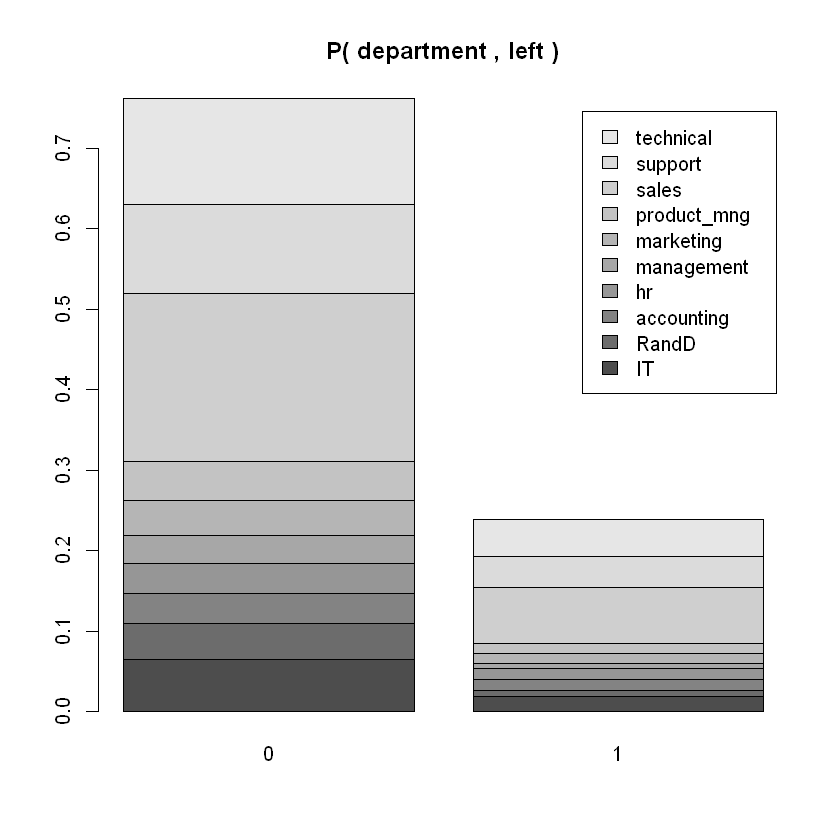

[1] "P(target, var):"
        left
salary        0      1
  high   0.0742 0.0048
  low    0.3421 0.1464
  medium 0.3456 0.0869
[1] "########################"
[1] "P(target):"
[1] "Check:"

     0      1 
0.7619 0.2381 
     0      1 
0.7619 0.2381 
[1] "########################"
[1] "P(var):"
[1] "Check:"

  high    low medium 
0.0790 0.4885 0.4325 
  high    low medium 
0.0790 0.4885 0.4325 
[1] "########################"
[1] "P(target|var):"
        left
salary            0          1
  high   0.93924051 0.06075949
  low    0.70030706 0.29969294
  medium 0.79907514 0.20092486
[1] "Check:"
  high    low medium 
     1      1      1 
[1] "########################"
[1] "P(var|target):"
        left
salary            0          1
  high   0.09738811 0.02015960
  low    0.44900906 0.61486770
  medium 0.45360284 0.36497270
[1] "Check:"
0 1 
1 1 
[1] "########################"


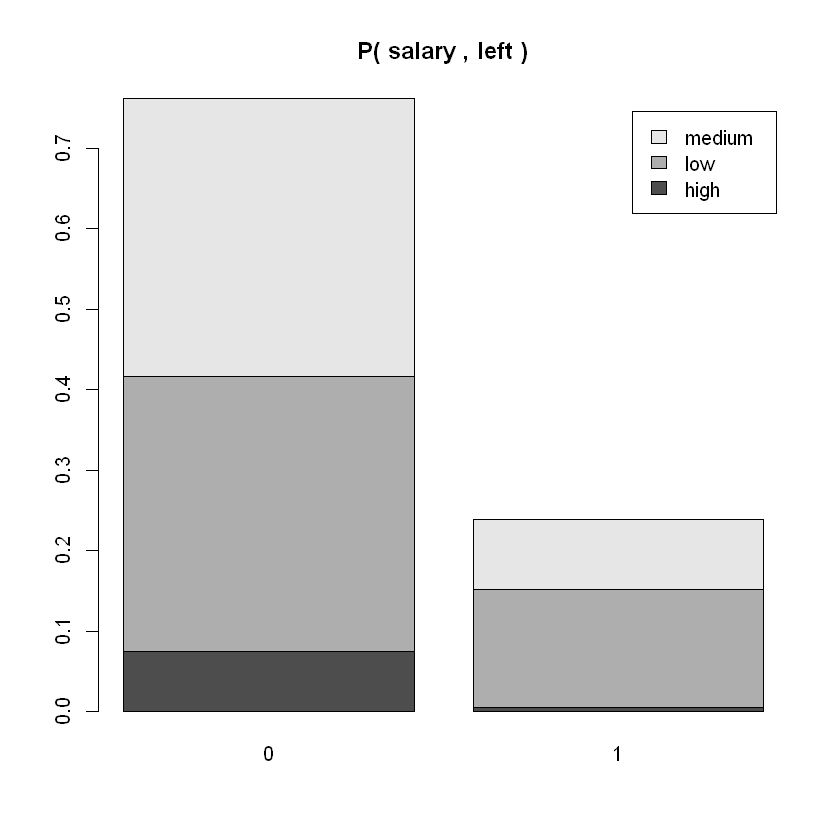

In [16]:
for (i in qualitatives_attributes_col_idx) {
  QualitativeAttrsTheory(data, i,target_variables_idx)
}

# Quantitatives Attributes

[1] "Correlation Matrix:"
                     satisfaction_level last_evaluation average_montly_hours
satisfaction_level           1.00000000       0.1083785          -0.01512616
last_evaluation              0.10837846       1.0000000           0.33678408
average_montly_hours        -0.01512616       0.3367841           1.00000000


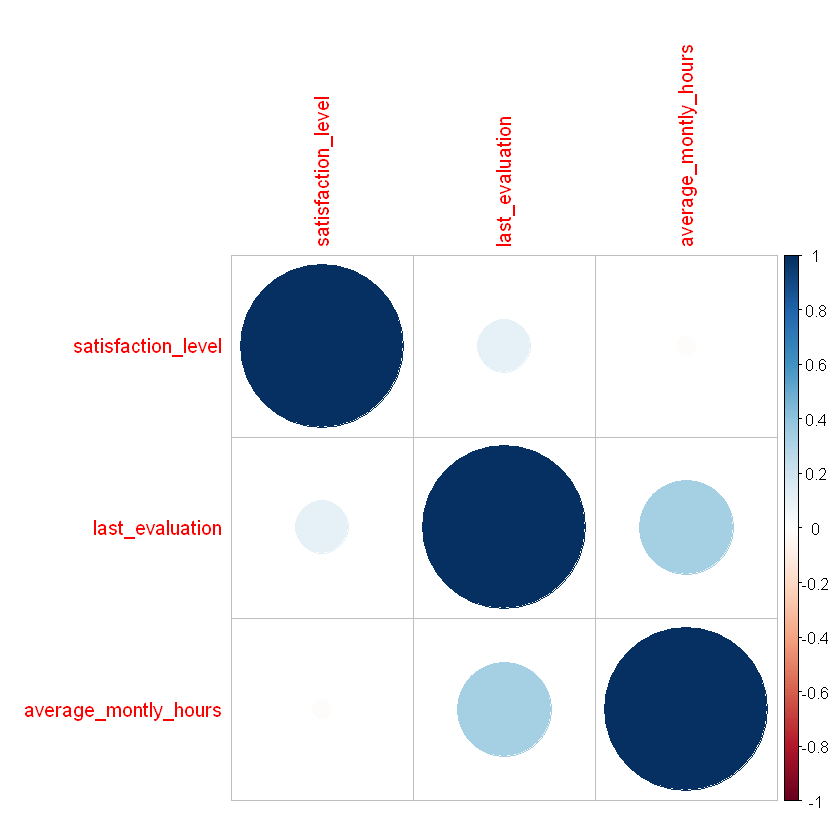

In [17]:
# Calculate correlation matrix for quantitative attributes
correlation_matrix <- cor(data[, quantitatives_attributes_col_idx])
print("Correlation Matrix:")
print(correlation_matrix)
corrplot(correlation_matrix, method = "circle")

In [18]:
generateQuantitativeAttributesAnalysisSummary <- function(data, target_variables_idx, quantitatives_attributes_col_idx){
  #Calculate means
  overallMeans <- round(colMeans(data[, quantitatives_attributes_col_idx, drop=FALSE]),2)

  #Calculate variances 
  overallVar <- round(apply(data[, quantitatives_attributes_col_idx, drop=FALSE], 2, var),2)
  
  # TODO : Generalize this part to loop on the Target Value and generate each conditional means
  #Calculate conditional means P(f|left=0)
  condMeansStay <- round(colMeans(data[data[,target_variables_idx ]==0,quantitatives_attributes_col_idx, drop=FALSE]),2)

  covMatrixStay <- var(data[data[, target_variables_idx] == 0, quantitatives_attributes_col_idx, drop = FALSE])
  condStdDevStay <- round(sqrt(diag(covMatrixStay)),2)

  #Calculate conditional Means P(f|left=1)
  condMeansLeft <- round(colMeans(data[data[,target_variables_idx]==1,quantitatives_attributes_col_idx, drop=FALSE]),2)
  covMatrixLeft <- var(data[data[, target_variables_idx] == 1, quantitatives_attributes_col_idx, drop = FALSE])
  condStdDevLeft <- round(sqrt(diag(covMatrixLeft)),2)

  #Calculate Standard deviations
  stdDevs <- round(sqrt(diag(var(data[,quantitatives_attributes_col_idx, drop=FALSE]))),2)

  attributesScore<-round(abs(condMeansLeft-condMeansStay)/stdDevs,2)

  summary <- data.frame(
    Mean = overallMeans,
    Variance = overallVar,
    Std_Dev = stdDevs,
    Mean_Stay = condMeansStay,
    Std_Dev_Stay = condStdDevStay,
    Mean_Left = condMeansLeft,
    Std_Dev_Left = condStdDevLeft,
    Importance_Score = attributesScore
  )
  
  sorted_summary <- summary[order(-summary$Importance_Score), ]  # Sort by Importance Score descending

  return(sorted_summary)
}

In [19]:
saveQuantitativeAttributesAnalysisSummary <- function(wd, folder_name, file_name, summary){
  # Set working directory to the folder of the script
  setwd(wd)

  # Ensure output directory exists
  output_dir <- file.path(wd, folder_name)
  if (!dir.exists(output_dir)) {
    dir.create(output_dir, recursive = TRUE)
  }

  # Construct full file path for saving the PNG
  full_file_path <- file.path(output_dir, paste0(file_name, ".png"))

  # Save the table as a PNG
  png(full_file_path, width = 1200, height = 500)
  grid.table(summary)
  dev.off()
}

In [20]:
summary <- generateQuantitativeAttributesAnalysisSummary(
  data, 
  target_variables_idx, 
  quantitatives_attributes_col_idx
)
print(summary)
saveQuantitativeAttributesAnalysisSummary(
  working_directory, 
  output_folder, 
  "quantitative_attributes_summary_table",
  summary
)


                       Mean Variance Std_Dev Mean_Stay Std_Dev_Stay Mean_Left
satisfaction_level     0.61     0.06    0.25      0.67         0.22      0.44
average_montly_hours 200.69  2484.20   49.84    198.77        45.70    206.83
last_evaluation        0.72     0.03    0.17      0.72         0.16      0.72
                     Std_Dev_Left Importance_Score
satisfaction_level           0.26             0.92
average_montly_hours        60.85             0.16
last_evaluation              0.20             0.00


png 
  2

In [21]:
# Function to visualize the empirical distribution of a quantitative attribute
visualizeEmpiricalDistributionOfQuantitativeAttribute <- function(wd, folder_name, data, idx) {


  # Ensure output directory exists
  output_dir <- ensure_output_directory(wd, folder_name)
  
  # get variable names
  var_name <- names(data)[idx]

  # Create the full path for the PDF file
  full_pdf_path <- file.path(output_dir, paste0(var_name,"_empirical", ".pdf"))

  # Open a PDF to save the plots
  pdf(file = full_pdf_path, width = 12, height = 6)

  # Set up a 1-row, 1-column layout for the plots
  par(mfrow = c(1, 1), mar = c(7, 4, 4, 2) + 0.1)

  # Calculate summary statistics for the attribute
  avg <- mean(data[, idx])
  var <- var(data[, idx])
  std_dev <- sqrt(var)

  # Create the histogram and save its output
  hist_output <- hist(data[, idx],
                      main = paste("Empirical distribution of ", var_name),
                      xlab = var_name,
                      breaks = 20)

  # Draw a vertical line for the mean
  abline(v = avg, col = "red")

  # Extract the maximum frequency from the histogram output
  max_frequency <- max(hist_output$counts)

  # Set the y value for text labels and lines relative to the histogram height
  y_line <- max_frequency * 0.1       # Set line height at 10% of the max frequency for visibility
  y_text_sd <- max_frequency * 0.15   # Set text height slightly above the line
  y_text_34 <- max_frequency * 0.5    # Set "34% of data" labels around 50% of the max frequency for better visibility

  #######################################################
  # Draw a line representing the standard deviation range
  # This region theoretically contains 68% of the data on each side around the mean if the attribute is normally distributed
  points(x = c(avg - std_dev, avg + std_dev), y = c(y_line, y_line), type = "l", col = "darkgreen")

  # Add labels for μ - σ and μ + σ
  text(x = avg - std_dev, y = y_text_sd, labels = TeX("$\\mu_X-\\sigma_X$"), col = "blue", cex = 1)
  text(x = avg + std_dev, y = y_text_sd, labels = TeX("$\\mu_X+\\sigma_X$"), col = "blue", cex = 1)

  # Draw vertical lines at μ - σ and μ + σ
  abline(v = avg - std_dev, col = "darkgreen")
  abline(v = avg + std_dev, col = "darkgreen")

  # Add labels indicating "34% of data" on either side of the mean
  text(x = avg - 0.5 * std_dev, y = y_text_34, labels = "34% of data", col = "blue", cex = 1)
  text(x = avg + 0.5 * std_dev, y = y_text_34, labels = "34% of data", col = "blue", cex = 1)
  #######################################################

  # Close the PDF device
  dev.off()
}


In [22]:
# Function to visualize conditional distributions of an attribute for two groups and save the output
visualizeConditionalDistribution <- function(wd, folder_name, data, idx, target_idx) {

  # Ensure output directory exists
  output_dir <- ensure_output_directory(wd, folder_name)

  # get variable names
  var_name <- names(data)[idx]

  # Create the full path for the PDF file
  full_pdf_path <- file.path(output_dir, paste0(var_name,"_conditional", ".pdf"))

  # Open a PDF to save the plots
  pdf(file = full_pdf_path, width = 12, height = 6)

  # Set up a 1-row, 2-column layout for the plots
  par(mfrow = c(1, 1), mar = c(7, 4, 4, 2) + 0.1)

  # Calculate the range for the bins
  min_x <- min(data[, idx])
  max_x <- max(data[, idx])
  breaks <- seq(from = min_x, to = max_x, length.out = 20)

  # Create the histogram for people who left (target variable = 1)
  hist(
          data[data[, target_idx] == 1, idx],
          col = rgb(red = 1, green = 0, blue = 0, alpha = 0.5),
          xlab = var_name,
          main = paste("Density of", var_name, "for P(", var_name, "| left=1), P(", var_name, "| left=0)"),
          breaks = breaks,
          freq = FALSE
  )

  # Add the histogram for people who stayed (target variable = 0)
  hist(
          data[data[, target_idx] == 0, idx],
          col = rgb(red = 0, green = 1, blue = 0, alpha = 0.5),
          breaks = breaks,
          freq = FALSE,
          add = TRUE
  )

  # Add a legend to the plot
  legend("topright",
         legend = c("left=0", "left=1"),
         fill = c(rgb(red = 0, green = 1, blue = 0, alpha = 0.5),
                  rgb(red = 1, green = 0, blue = 0, alpha = 0.5)))

  # Close the PDF device
  dev.off()
}


In [33]:
# Define the index of the variable and target variable
for (i in quantitatives_attributes_col_idx) {
  visualizeEmpiricalDistributionOfQuantitativeAttribute(
          working_directory, 
          output_folder, 
          data, 
          i
  )
}

In [32]:
# Define the index of the variable and target variable
for (i in quantitatives_attributes_col_idx) {
  visualizeConditionalDistribution(
          working_directory, 
          output_folder, 
          data, 
          i, 
          target_variables_idx
  )
}

In [62]:
# Helper Function to calculate conditional probability P(target = 1 | lower_threshold <= quantitative column <= upper_threshold)
# This function is used to calculate the probabilities present in the report conclusion
calculate_conditional_probability_interval_by_index <- function(data, column_idx, target_idx, lower_threshold, upper_threshold, target_value) {

  # Extract the column and target variables using the provided indices
  column <- data[, column_idx]

  # Filter the rows where the specified column is within the interval
  filtered_data <- data[column >= lower_threshold & column < upper_threshold, ]

  # Check if the filtered data is not empty to avoid division by zero
  if (nrow(filtered_data) == 0) {
    warning("No data points in the specified interval")
    return(NA)
  }

  # Calculate the conditional probability P(target = target_value | lower_threshold <= column <= upper_threshold)
  count_target_given_interval <- nrow(filtered_data[filtered_data[, target_idx] == target_value, ])
  prob_target_given_interval <- count_target_given_interval / nrow(filtered_data)

  # Return the result
  return(prob_target_given_interval)
}

# Example usage
lower_threshold_value <- 240
upper_threshold_value <- 270
column_index <- 5  # For 'average_montly_hours'
target_value <- 1 

conditional_probability_interval <- calculate_conditional_probability_interval_by_index(data, column_index, target_variables_idx, lower_threshold_value, upper_threshold_value, target_value)

# Print the result
print(conditional_probability_interval)


[1] 0.283871


In [25]:
# Function to create a scatter plot for the top two most important quantitative attributes
scatterPlotTopTwoAttributes <- function(wd, folder_name, data, quantitatives_attributes_col_idx, target_variables_idx) {

  # Ensure output directory exists
  output_dir <- ensure_output_directory(wd, folder_name)
  

  # Generate summary of quantitative attributes
  summary <- generateQuantitativeAttributesAnalysisSummary(data, target_variables_idx, quantitatives_attributes_col_idx)
  
  most_important_attributes_names <- row.names(summary)[1:2]
  x_idx <- which(names(data)== most_important_attributes_names[1])
  y_idx <- which(names(data)== most_important_attributes_names[2])

  # Create the full path for the PDF file
  full_pdf_path <- file.path(output_dir, paste0(most_important_attributes_names[1], "_",most_important_attributes_names[2],"_scatter", ".pdf"))

  # Open a PDF to save the plots
  pdf(file = full_pdf_path, width = 12, height = 6)

  # Set up a 1-row, 2-column layout for the plots
  par(mfrow = c(1, 1), mar = c(7, 4, 4, 2) + 0.1)

  # Print the names of the two most important attributes
  print(paste("Top two most important attributes:", colnames(data)[c(x_idx,y_idx)]))

  # Extract the columns for the top two attributes
  x <- data[, x_idx]
  y <- data[, y_idx]
  target <- factor(data[, target_variables_idx])

  # Create the scatter plot
  plot(
    x, y,
    col = target,
    pch = as.numeric(target),
    xlab = colnames(data)[x_idx],
    ylab = colnames(data)[y_idx],
    main = "Scatter Plot of Top 2 Attributes Left status"
  )

  # Add a legend to the plot
  legend("topright",
         legend = levels(target),
         col = 1:length(levels(target)),
         pch = 1:length(levels(target)),
         title = "Left status")

  # Close the PDF device
  dev.off()
}



In [26]:
# Example usage
scatterPlotTopTwoAttributes(working_directory, output_folder, data, quantitatives_attributes_col_idx, target_variables_idx)

[1] "Top two most important attributes: satisfaction_level"  
[2] "Top two most important attributes: average_montly_hours"


png 
  2

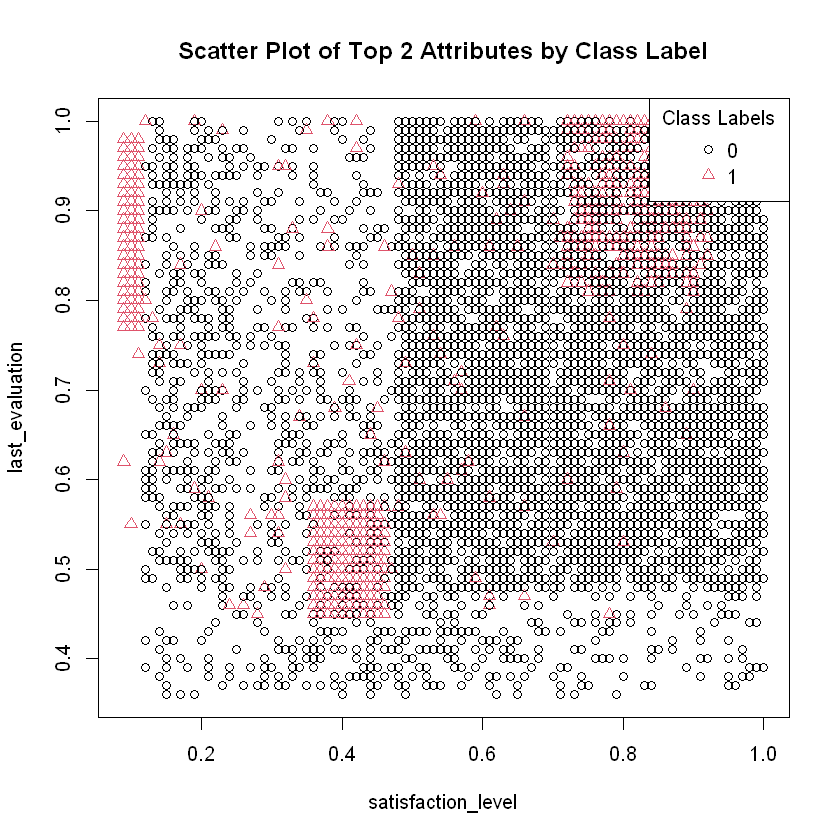

In [27]:
# Extract the columns for the top two attributes
x <- data[, 2]
y <- data[, 3]
target <- factor(data[, target_variables_idx])

# Create the scatter plot
plot(
  x, y,
  col = target,
  pch = as.numeric(target),
  xlab = colnames(data)[2],
  ylab = colnames(data)[3],
  main = "Scatter Plot of Top 2 Attributes by Class Label"
)

# Add a legend to the plot
legend("topright",
       legend = levels(target),
       col = 1:length(levels(target)),
       pch = 1:length(levels(target)),
       title = "Class Labels")


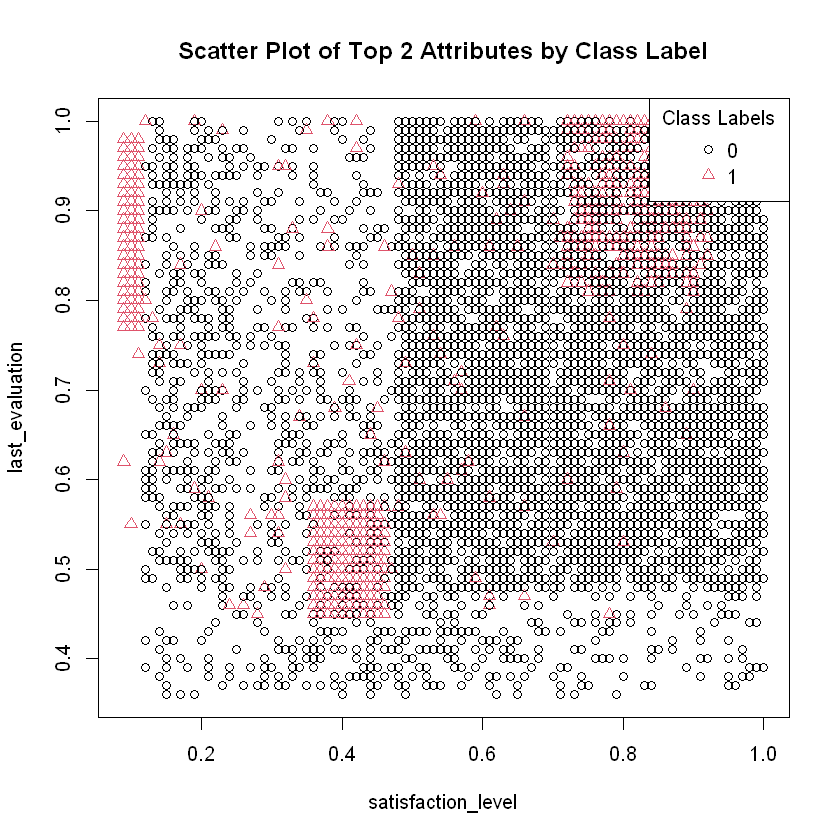

In [28]:
# Extract the columns for the top two attributes
x <- data[, 2]
y <- data[, 3]
target <- factor(data[, target_variables_idx])

# Create the scatter plot
plot(
  x, y,
  col = target,
  pch = as.numeric(target),
  xlab = colnames(data)[2],
  ylab = colnames(data)[3],
  main = "Scatter Plot of Top 2 Attributes by Class Label"
)

# Add a legend to the plot
legend("topright",
       legend = levels(target),
       col = 1:length(levels(target)),
       pch = 1:length(levels(target)),
       title = "Class Labels")


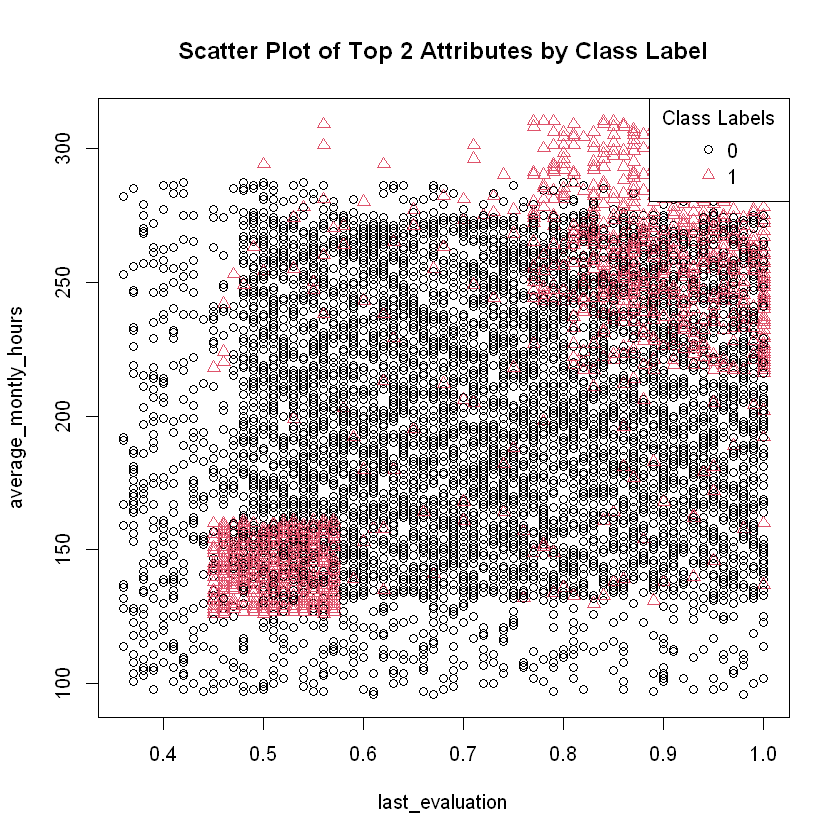

In [29]:
# Extract the columns for the top two attributes
x <- data[, 3]
y <- data[, 5]
target <- factor(data[, target_variables_idx])

# Create the scatter plot
plot(
  x, y,
  col = target,
  pch = as.numeric(target),
  xlab = colnames(data)[3],
  ylab = colnames(data)[5],
  main = "Scatter Plot of Top 2 Attributes by Class Label"
)

# Add a legend to the plot
legend("topright",
       legend = levels(target),
       col = 1:length(levels(target)),
       pch = 1:length(levels(target)),
       title = "Class Labels")


In [30]:
# Function to visualize normal distribution and compare with empirical histograms
QuantitativeAttrsTheory <- function(data, variable_idx, target_idx) {
  
  # Extract the selected variable and target variable
  var_name <- colnames(data)[variable_idx]
  #target_name <- colnames(data)[target_idx]

  # Extract the summary from the generateQuantitativeAttributesAnalysisSummary function
  summary <- generateQuantitativeAttributesAnalysisSummary(data, target_idx, c(variable_idx))
  print(summary)
  
  overall_mean <- summary$Mean
  overall_std <- summary$Std_Dev
  
  mean_target_0 <- summary$Mean_Stay
  std_target_0 <- summary$Std_Dev_Stay

  mean_target_1 <- summary$Mean_Left
  std_target_1 <- summary$Std_Dev_Left

  # Plot the empirical histogram of the selected variable
  hist(data[, variable_idx],
       probability = TRUE,
       breaks = 20,
       main = paste("Empirical vs Normal Distribution for", var_name),
       xlab = var_name,
       col = rgb(0.8, 0.8, 0.8, 0.5))

  # Add the overall normal distribution curve
  curve(dnorm(x, mean = overall_mean, sd = overall_std),
        col = "blue", lwd = 2, add = TRUE,
        ylab = "Density")

  # Add normal distribution for P(f | y = 0)
  curve(dnorm(x, mean = mean_target_0, sd = std_target_0),
        col = "red", lwd = 2, add = TRUE, lty = 2)

  # Add normal distribution for P(f | y = 1)
  curve(dnorm(x, mean = mean_target_1, sd = std_target_1),
        col = "green", lwd = 2, add = TRUE, lty = 3)

  # Add legend
  legend("topright",
         legend = c("P(f)", "P(f | y = 0)", "P(f | y = 1)"),
         col = c("blue", "red", "green"),
         lty = c(1, 2, 3),
         lwd = 2)
}

                   Mean Variance Std_Dev Mean_Stay Std_Dev_Stay Mean_Left
satisfaction_level 0.61     0.06    0.25      0.67         0.22      0.44
                   Std_Dev_Left Importance_Score
satisfaction_level         0.26             0.92
                Mean Variance Std_Dev Mean_Stay Std_Dev_Stay Mean_Left
last_evaluation 0.72     0.03    0.17      0.72         0.16      0.72
                Std_Dev_Left Importance_Score
last_evaluation          0.2                0


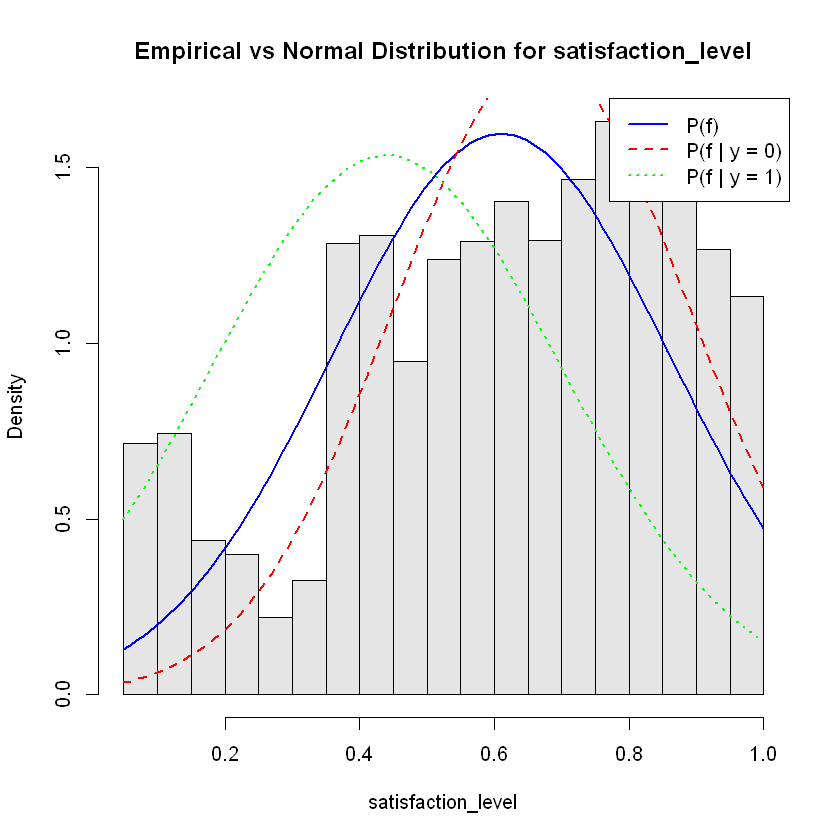

                       Mean Variance Std_Dev Mean_Stay Std_Dev_Stay Mean_Left
average_montly_hours 200.69   2484.2   49.84    198.77         45.7    206.83
                     Std_Dev_Left Importance_Score
average_montly_hours        60.85             0.16


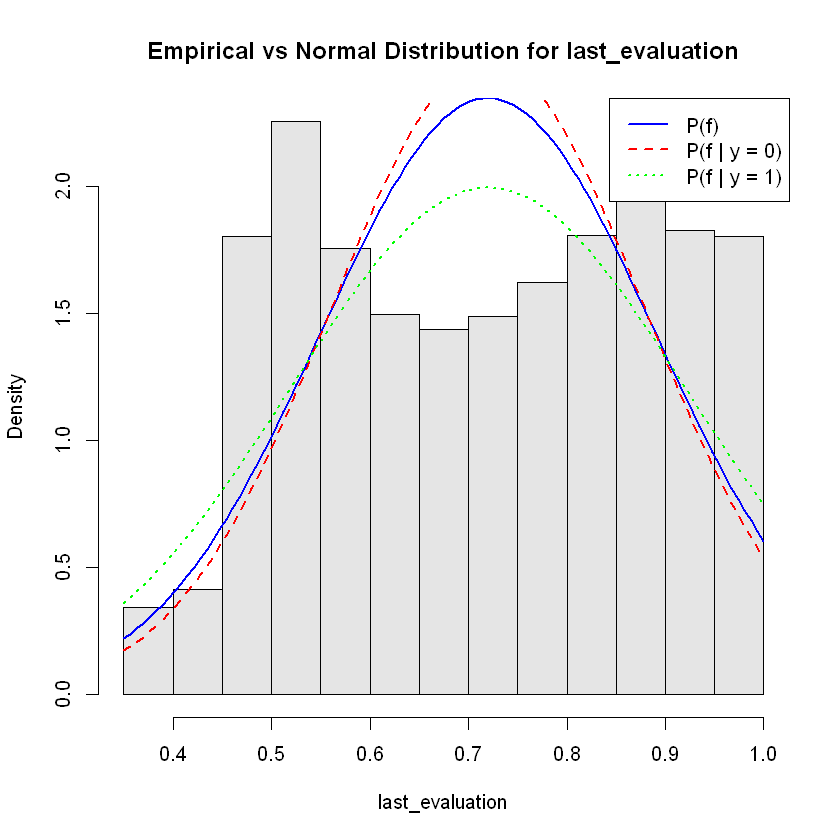

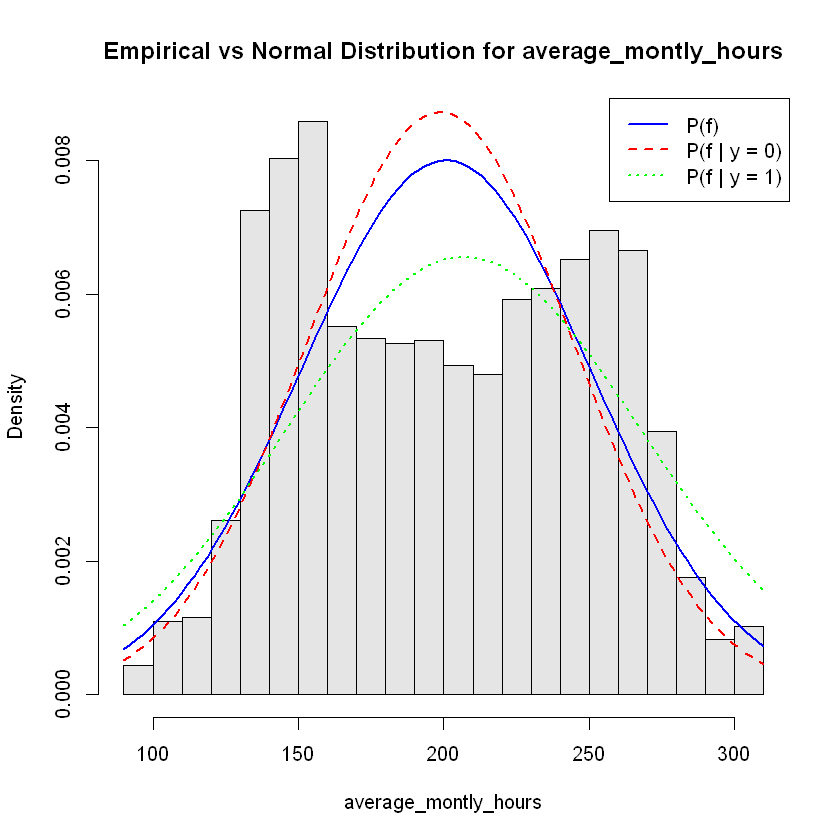

In [31]:
for (i in quantitatives_attributes_col_idx) {
  QuantitativeAttrsTheory(data, i, target_variables_idx)
}